In [1]:
#Import all libraries here
import numpy as np
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
import wget
import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

os.chdir('E:/Study/SIT719 - Analytics For Security and Privacy/Ontrack Tasks/Task5/')

In [2]:
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data)

100% [..................................................................................] 500 / 500

In [3]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [4]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [5]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'



train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis=1, inplace=True)

In [6]:
#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

In [7]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [8]:
train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00
logged_in,125973.00,0.40,0.49,0.00,0.00,0.00,1.00,1.00
root_shell,125973.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
su_attempted,125973.00,0.00,0.05,0.00,0.00,0.00,0.00,2.00
is_host_login,125973.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
is_guest_login,125973.00,0.01,0.10,0.00,0.00,0.00,0.00,1.00


In [9]:
train_df['su_attempted'].value_counts()

0    125893
2        59
1        21
Name: su_attempted, dtype: int64

In [10]:
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
print(train_df['su_attempted'].value_counts())
print(test_df['su_attempted'].value_counts())

0    125952
1        21
Name: su_attempted, dtype: int64
0    22542
1        2
Name: su_attempted, dtype: int64


In [11]:
print(train_df['num_outbound_cmds'].value_counts())
#Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

0    125973
Name: num_outbound_cmds, dtype: int64


In [12]:
#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
print(combined_df_raw.shape)
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)
print(combined_df.shape)

train_x = combined_df[:len(train_x_raw)]
print(train_x.shape)
test_x = combined_df[len(train_x_raw):]
print(test_x.shape)

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

(148517, 40)
(148517, 118)
(125973, 118)
(22544, 118)


In [13]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,...,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00
mean,287.14,45566.74,19779.11,0.00,0.02,0.00,0.20,0.00,0.40,0.28,...,0.09,0.01,0.00,0.02,0.28,0.00,0.00,0.00,0.59,0.00
std,2604.52,5870331.18,4021269.15,0.01,0.25,0.01,2.15,0.05,0.49,23.94,...,0.28,0.11,0.03,0.14,0.45,0.05,0.03,0.02,0.49,0.05
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,44.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,0.00,276.00,516.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
max,42908.00,1379963888.00,1309937401.00,1.00,3.00,3.00,77.00,5.00,1.00,7479.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [14]:
# Experimenting with StandardScaler on the single 'duration' feature
durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count   125973.00
mean         0.00
std          1.00
min         -0.11
25%         -0.11
50%         -0.11
75%         -0.11
max         16.36
dtype: float64

In [15]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count   125973.00
mean         0.01
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
dtype: float64

In [16]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler().fit(durations)
robust_scaled_durations = robust_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count   125973.00
mean       287.14
std       2604.52
min          0.00
25%          0.00
50%          0.00
75%          0.00
max      42908.00
dtype: float64

In [17]:
# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count   125973.00
mean         0.01
std          0.06
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
dtype: float64

<AxesSubplot:>

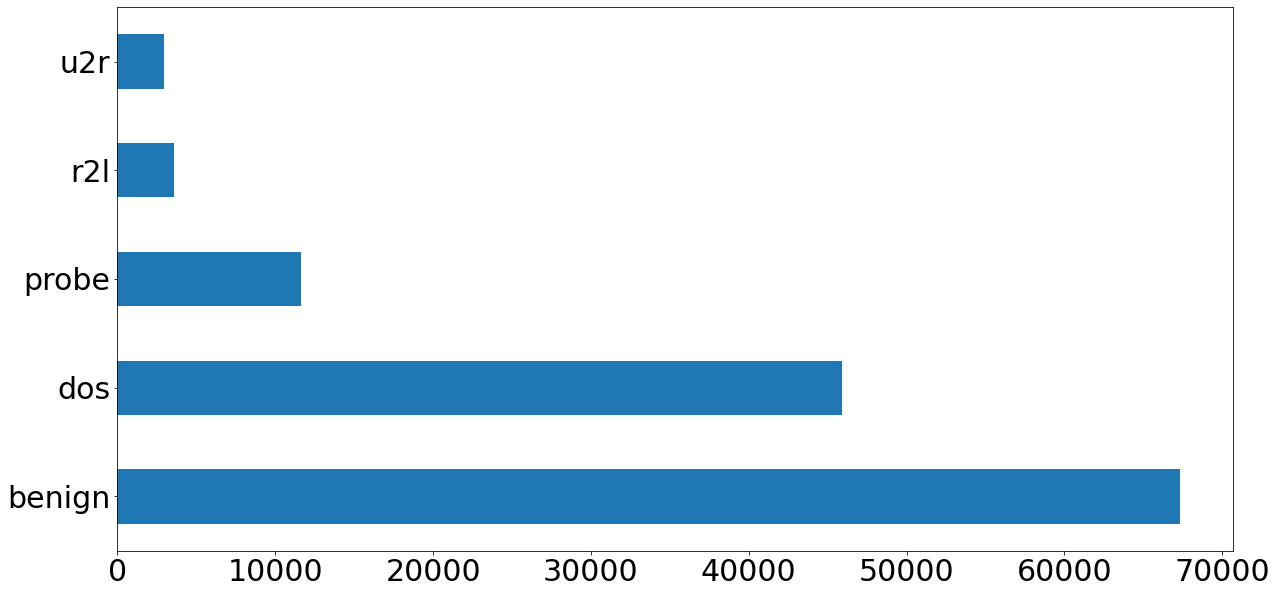

In [18]:
# Let's proceed with StandardScaler- Apply to all the numeric columns
standard_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    

train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

### Classification steps starts from here

<b> Step 6 : Predictive Modelling </b> 

Here we have used 5 classifier for our dataset and we have predicted the accuracy, error, f1 score, etc

<n> <b> 1) Decision Tree </b> </n>
<br> <b> 2) Random Forest </b> </br>
<br> <b> 3) K-Nearest Neighbor(KNN) </b> </br>
<br> <b> 4) XGBoost </b> </br>
<br> <b> 5) Logistic Regression </b> </br>


### 1) Decision tree classifier

In [19]:
# 5-class classification version
t0 = time.time() #Start timer
decision_classifier = DecisionTreeClassifier(random_state=17)
decision_classifier.fit(train_x, train_Y)

pred_y = decision_classifier.predict(test_x)
t1 = time.time() #Stop timer

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
accuracy = accuracy_score(pred_y, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results)
print('Accuracy of our Decision tree model is:-', accuracy)
print('Error of our Decision tree model is:-',error)

Time taken:-  2.5515339374542236 secs
Confusion Matrix:- [[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
Accuracy of our Decision tree model is:- 0.7621096522356281
Error of our Decision tree model is:- 0.2378903477643719


In [20]:
# 5-class classification version
t0 = time.time() #Start timer
decision_classifier1 = DecisionTreeClassifier(random_state=17, criterion='entropy', splitter='random', 
                                            max_features='sqrt')
decision_classifier1.fit(train_x, train_Y)

pred_y = decision_classifier1.predict(test_x)
t1 = time.time() #Stop timer

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
accuracy = accuracy_score(pred_y, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results)
print('Accuracy of our Decision tree model is:-', accuracy)
print('Error of our Decision tree model is:-',error)

Time taken:-  0.48072195053100586 secs
Confusion Matrix:- [[9450   49  205    6    1]
 [ 962 6223  231  220    0]
 [ 593  322 1504    4    0]
 [2241    1    8  320    4]
 [ 117    0   64    9   10]]
Accuracy of our Decision tree model is:- 0.776570262597587
Error of our Decision tree model is:- 0.223429737402413


In [21]:
print(results)
print(classification_report(test_Y,pred_y))

[[9450   49  205    6    1]
 [ 962 6223  231  220    0]
 [ 593  322 1504    4    0]
 [2241    1    8  320    4]
 [ 117    0   64    9   10]]
              precision    recall  f1-score   support

      benign       0.71      0.97      0.82      9711
         dos       0.94      0.81      0.87      7636
       probe       0.75      0.62      0.68      2423
         r2l       0.57      0.12      0.20      2574
         u2r       0.67      0.05      0.09       200

    accuracy                           0.78     22544
   macro avg       0.73      0.52      0.53     22544
weighted avg       0.78      0.78      0.75     22544



In [22]:
y_pred_proba = decision_classifier1.predict_proba(test_x)
print('ROC_AUC Score is:- ',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)

ROC_AUC Score is:-  72.16825545554153


In [23]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, pred_y)*100)

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_Y, pred_y, average='weighted')*100)

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_Y, pred_y, average='weighted')*100)

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(test_Y, pred_y, average='weighted')*100)

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(test_Y, pred_y)*100)

# ROC AUC
print('ROC_AUC Score one vs rest:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)
print('ROC_AUC Score one vs one:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovo')*100)

Accuracy: 77.6570262597587
Precision: 77.58482349377637
Recall: 77.6570262597587
F1 Score: 74.61108225539728
Cohens kappa: 64.71145252540138
ROC_AUC Score one vs rest: 72.16825545554153
ROC_AUC Score one vs one: 69.79687671101783


###### FPR, TPR Calculation based on confusion matrix

In [24]:
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('False Alarm Rate (FPR) is:',list(FPR))

False Alarm Rate (FPR) is: [0.3049170108314502, 0.024953045344781325, 0.025247254112618658, 0.011967951927891837, 0.00022377372001432152]


### 2) Random Forest Classifier

In [25]:
#Iteration 1

t0=time.time()
randomforest_clf= RandomForestClassifier(random_state=55)

randomforest_clf.fit(train_x, train_Y)

pred_y2 = randomforest_clf.predict(test_x)
t1 = time.time()

results_rf = confusion_matrix(test_Y, pred_y2)
error_rf = zero_one_loss(test_Y, pred_y2)
accuracy_rf = accuracy_score(pred_y2, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_rf)
print('Accuracy of our Random Forest model is:-', accuracy_rf)
print('Error of our  Random Forest model is:-',error_rf)

Time taken:-  16.643442153930664 secs
Confusion Matrix:- [[9457   67  186    0    1]
 [1710 5841   85    0    0]
 [ 822  163 1438    0    0]
 [2512    0    1   60    1]
 [ 195    0    1    2    2]]
Accuracy of our Random Forest model is:- 0.7451206529453513
Error of our  Random Forest model is:- 0.25487934705464865


In [26]:
#Iteration 2

t0=time.time()
randomforest_clf= RandomForestClassifier(n_estimators=11, criterion='entropy',min_samples_split=3, random_state=55, 
                                         n_jobs=-1)

randomforest_clf.fit(train_x, train_Y)

pred_y2 = randomforest_clf.predict(test_x)
t1 = time.time()

results_rf = confusion_matrix(test_Y, pred_y2)
error_rf = zero_one_loss(test_Y, pred_y2)
accuracy_rf = accuracy_score(pred_y2, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_rf)
print('Accuracy of our Random Forest model is:-', accuracy_rf)
print('Error of our Random Forest model is:-',error_rf)

Time taken:-  1.5043408870697021 secs
Confusion Matrix:- [[9458   56  194    2    1]
 [1903 5659   74    0    0]
 [ 669  168 1586    0    0]
 [2166    0    2  403    3]
 [ 180    0   12    4    4]]
Accuracy of our Random Forest model is:- 0.7589602555003548
Error of our Random Forest model is:- 0.24103974449964516


In [27]:
print(results_rf)
print(classification_report(test_Y,pred_y2))

[[9458   56  194    2    1]
 [1903 5659   74    0    0]
 [ 669  168 1586    0    0]
 [2166    0    2  403    3]
 [ 180    0   12    4    4]]
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.74      0.84      7636
       probe       0.85      0.65      0.74      2423
         r2l       0.99      0.16      0.27      2574
         u2r       0.50      0.02      0.04       200

    accuracy                           0.76     22544
   macro avg       0.79      0.51      0.53     22544
weighted avg       0.82      0.76      0.73     22544



In [28]:
y_pred_proba = randomforest_clf.predict_proba(test_x)
print('ROC_AUC Score is:- ',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)

ROC_AUC Score is:-  82.54240900129204


In [29]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, pred_y2)*100)

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_Y, pred_y2, average='weighted')*100)

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_Y, pred_y2, average='weighted')*100)

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(test_Y, pred_y2, average='weighted')*100)

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(test_Y, pred_y2)*100)

# ROC AUC
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovo')*100)

Accuracy: 75.89602555003549
Precision: 81.74057314235074
Recall: 75.89602555003549
F1 Score: 73.24944847715828
Cohens kappa: 61.49165247726038
ROC_AUC Score: 82.54240900129204
ROC_AUC Score: 81.0890193863566


###### FPR, TPR Calculation based on confusion matrix

In [30]:
FP = results_rf.sum(axis=0) - np.diag(results_rf)  
FN = results_rf.sum(axis=1) - np.diag(results_rf)
TP = np.diag(results_rf)
TN = results_rf.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR_rf = TP/(TP+FN)
# Specificity or true negative rate
TNR_rf = TN/(TN+FP) 
# Precision or positive predictive value
PPV_rf = TP/(TP+FP)
# Negative predictive value
NPV_rf = TN/(TN+FN)
# Fall out or false positive rate
FPR_rf = FP/(FP+TN)
# False negative rate
FNR_rf = FN/(TP+FN)

print('False Alarm Rate (FPR) is:',list(FPR_rf))

False Alarm Rate (FPR) is: [0.3832307332657991, 0.015025489669975852, 0.014015207991650515, 0.00030045067601402103, 0.00017901897601145723]


### 3) XGBoost

In [31]:
#Iteration 1

t0=time.time()
xgb_clf = XGBClassifier(random_state=55, n_jobs=-1)
xgb_clf.fit(train_x, train_Y)

pred_y5 = xgb_clf.predict(test_x)
t1 = time.time()

results_xgb = confusion_matrix(test_Y, pred_y5)
error_xgb = zero_one_loss(test_Y, pred_y5)
accuracy_xgb = accuracy_score(pred_y5, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_xgb)
print('Accuracy of our Decision tree model is:-', accuracy_xgb)
print('Error of our Decision tree model is:-',error_xgb)

[00:23:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken:-  156.3872525691986 secs
Confusion Matrix:- [[9436   69  204    1    1]
 [1321 6219   96    0    0]
 [ 736  165 1522    0    0]
 [2375    0    2  195    2]
 [ 191    0    2    0    7]]
Accuracy of our Decision tree model is:- 0.7708924769339958
Error of our Decision tree model is:- 0.22910752306600424


In [32]:
#Iteration 2

t0=time.time()
# xgb_clf = XGBClassifier(random_state=55, n_jobs=-1, min_child_weight=5, gamma=0.4, learning_rate=0.10, 
#                         objective='multi:softmax')
xgb_clf = XGBClassifier(random_state=55, n_jobs=-1, min_child_weight=5, gamma=0.3, learning_rate=0.10)
# xgb_clf = XGBClassifier(random_state=55, n_jobs=-1, min_child_weight=5, gamma=0.3, learning_rate=0.10, n_estimators=300)
xgb_clf.fit(train_x, train_Y)

pred_y5 = xgb_clf.predict(test_x)
t1 = time.time()

results_xgb = confusion_matrix(test_Y, pred_y5)
error_xgb = zero_one_loss(test_Y, pred_y5)
accuracy_xgb = accuracy_score(pred_y5, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_xgb)
print('Accuracy of our XGBoost model is:-', accuracy_xgb)
print('Error of our XGBoost model is:-',error_xgb)

[00:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken:-  157.17039847373962 secs
Confusion Matrix:- [[9435   70  204    1    1]
 [1228 6212  196    0    0]
 [ 742  166 1515    0    0]
 [2138    0    5  428    3]
 [ 188    0    2    2    8]]
Accuracy of our XGBoost model is:- 0.7806068133427964
Error of our XGBoost model is:- 0.21939318665720364


In [33]:
print(results_xgb)
print(classification_report(test_Y,pred_y5))

[[9435   70  204    1    1]
 [1228 6212  196    0    0]
 [ 742  166 1515    0    0]
 [2138    0    5  428    3]
 [ 188    0    2    2    8]]
              precision    recall  f1-score   support

      benign       0.69      0.97      0.80      9711
         dos       0.96      0.81      0.88      7636
       probe       0.79      0.63      0.70      2423
         r2l       0.99      0.17      0.28      2574
         u2r       0.67      0.04      0.08       200

    accuracy                           0.78     22544
   macro avg       0.82      0.52      0.55     22544
weighted avg       0.83      0.78      0.75     22544



In [34]:
y_pred_proba = xgb_clf.predict_proba(test_x)
print('ROC_AUC Score is:- ',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)

ROC_AUC Score is:-  94.74995490800255


In [35]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, pred_y5)*100)

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_Y, pred_y5, average='weighted')*100)

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_Y, pred_y5, average='weighted')*100)

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(test_Y, pred_y5, average='weighted')*100)

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(test_Y, pred_y5)*100)

# ROC AUC
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovo')*100)

Accuracy: 78.06068133427964
Precision: 82.63208196595278
Recall: 78.06068133427964
F1 Score: 75.36823715740489
Cohens kappa: 65.1428451510276
ROC_AUC Score: 94.74995490800255
ROC_AUC Score: 89.69213936832912


###### FPR, TPR Calculation based on confusion matrix

In [36]:
FP = results_xgb.sum(axis=0) - np.diag(results_xgb)  
FN = results_xgb.sum(axis=1) - np.diag(results_xgb)
TP = np.diag(results_xgb)
TN = results_xgb.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR_xgb = TP/(TP+FN)
# Specificity or true negative rate
TNR_xgb = TN/(TN+FP) 
# Precision or positive predictive value
PPV_xgb = TP/(TP+FP)
# Negative predictive value
NPV_xgb = TN/(TN+FN)
# Fall out or false positive rate
FPR_xgb = FP/(FP+TN)
# False negative rate
FNR_xgb = FN/(TP+FN)

print('False Alarm Rate (FPR) is:',list(FPR_xgb))

False Alarm Rate (FPR) is: [0.33476194186861996, 0.0158304266165817, 0.020227622881566522, 0.00015022533800701052, 0.00017901897601145723]


### 4) KNN Classifier

In [37]:
#Iteration 1

t0=time.time()
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_x, train_Y)
pred_y3 = knn_clf.predict(test_x)
t1 = time.time()

results_knn = confusion_matrix(test_Y, pred_y3)
error_knn = zero_one_loss(test_Y, pred_y3)
accuracy_knn = accuracy_score(pred_y3, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_knn)
print('Accuracy of our KNN Classifier Model is:-', accuracy_knn)
print('Error of our KNN Classifier Model is:-',error_knn)

Time taken:-  170.93278455734253 secs
Confusion Matrix:- [[9444   54  207    5    1]
 [1630 5925   81    0    0]
 [ 614  180 1629    0    0]
 [2362    2   40  170    0]
 [ 170    0   17    4    9]]
Accuracy of our KNN Classifier Model is:- 0.7619322214336409
Error of our KNN Classifier Model is:- 0.23806777856635908


In [38]:
#Iteration 2

t0=time.time()
knn_clf = KNeighborsClassifier(n_neighbors=6, weights='distance', n_jobs=-1, metric='manhattan')
knn_clf.fit(train_x, train_Y)
pred_y3 = knn_clf.predict(test_x)
t1 = time.time()

results_knn = confusion_matrix(test_Y, pred_y3)
error_knn = zero_one_loss(test_Y, pred_y3)
accuracy_knn = accuracy_score(pred_y3, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_knn)
print('Accuracy of our KNN Classifier Model is:-', accuracy_knn)
print('Error of our KNN Classifier Model is:-',error_knn)

Time taken:-  120.05758500099182 secs
Confusion Matrix:- [[9440   55  212    3    1]
 [1562 6044   30    0    0]
 [ 671  171 1581    0    0]
 [2385    2    5  179    3]
 [ 168    0   17    4   11]]
Accuracy of our KNN Classifier Model is:- 0.7653921220723917
Error of our KNN Classifier Model is:- 0.2346078779276083


In [39]:
print(results_knn)
print(classification_report(test_Y,pred_y3))

[[9440   55  212    3    1]
 [1562 6044   30    0    0]
 [ 671  171 1581    0    0]
 [2385    2    5  179    3]
 [ 168    0   17    4   11]]
              precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.79      0.87      7636
       probe       0.86      0.65      0.74      2423
         r2l       0.96      0.07      0.13      2574
         u2r       0.73      0.06      0.10       200

    accuracy                           0.77     22544
   macro avg       0.84      0.51      0.53     22544
weighted avg       0.82      0.77      0.73     22544



In [40]:
y_pred_proba = knn_clf.predict_proba(test_x)
print('ROC_AUC Score is:- ',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)

ROC_AUC Score is:-  74.70229271522723


In [41]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, pred_y3)*100)

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_Y, pred_y3, average='weighted')*100)

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_Y, pred_y3, average='weighted')*100)

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(test_Y, pred_y3, average='weighted')*100)

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(test_Y, pred_y3)*100)

# ROC AUC
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovo')*100)

Accuracy: 76.53921220723917
Precision: 82.0727040281447
Recall: 76.53921220723917
F1 Score: 72.9490229344248
Cohens kappa: 62.41459288464504
ROC_AUC Score: 74.70229271522723
ROC_AUC Score: 73.02764937242165


###### FPR, TPR Calculation based on confusion matrix

In [42]:
FP = results_knn.sum(axis=0) - np.diag(results_knn)  
FN = results_knn.sum(axis=1) - np.diag(results_knn)
TP = np.diag(results_knn)
TN = results_knn.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR_knn = TP/(TP+FN)
# Specificity or true negative rate
TNR_knn = TN/(TN+FP) 
# Precision or positive predictive value
PPV_knn = TP/(TP+FP)
# Negative predictive value
NPV_knn = TN/(TN+FN)
# Fall out or false positive rate
FPR_knn = FP/(FP+TN)
# False negative rate
FNR_knn = FN/(TP+FN)

print('False Alarm Rate (FPR) is:',list(FPR_knn))

False Alarm Rate (FPR) is: [0.37294475181173536, 0.015293801985511135, 0.01312062024750261, 0.0003505257886830245, 0.00017901897601145723]


### 5) Logistic Regression

In [43]:
#Iteration 1

t0=time.time()
log_clf = LogisticRegression(random_state=55, n_jobs=-1)
log_clf.fit(train_x, train_Y)

pred_y8 = log_clf.predict(test_x)
t1 = time.time()

results_nb = confusion_matrix(test_Y, pred_y8)
error_nb = zero_one_loss(test_Y, pred_y8)
accuracy_nb = accuracy_score(pred_y8, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_nb)
print('Accuracy of our Logistic Regression model is:-', accuracy_nb)
print('Error of our Logistic Regression model is:-',error_nb)

Time taken:-  47.73702335357666 secs
Confusion Matrix:- [[8993   90  624    2    2]
 [1560 6052   24    0    0]
 [ 496   99 1825    3    0]
 [2471    2    2   99    0]
 [ 184    3    0    5    8]]
Accuracy of our Decision tree model is:- 0.7530606813342796
Error of our Decision tree model is:- 0.2469393186657204


In [44]:
#Iteration 2

t0=time.time()
log_clf = LogisticRegression(random_state=55,n_jobs=-1, class_weight='balanced')
log_clf.fit(train_x, train_Y)

pred_y8 = log_clf.predict(test_x)
t1 = time.time()

results_log = confusion_matrix(test_Y, pred_y8)
error_log = zero_one_loss(test_Y, pred_y8)
accuracy_log = accuracy_score(pred_y8, test_Y)

print('Time taken:- ', t1-t0, 'secs')
print('Confusion Matrix:-' ,results_log)
print('Accuracy of our Logistic Regression model is:-', accuracy_log)
print('Error of our Logistic Regression model is:-',error_log)

Time taken:-  61.28849530220032 secs
Confusion Matrix:- [[8910  434  285   45   37]
 [1477 6044   94    0   21]
 [ 159  156 2078   20   10]
 [1543    3    6  730  292]
 [  95    2    0   58   45]]
Accuracy of our Decision tree model is:- 0.7898775727466288
Error of our Decision tree model is:- 0.21012242725337116


In [45]:
print(results_log)
print(classification_report(test_Y,pred_y8))

[[8910  434  285   45   37]
 [1477 6044   94    0   21]
 [ 159  156 2078   20   10]
 [1543    3    6  730  292]
 [  95    2    0   58   45]]
              precision    recall  f1-score   support

      benign       0.73      0.92      0.81      9711
         dos       0.91      0.79      0.85      7636
       probe       0.84      0.86      0.85      2423
         r2l       0.86      0.28      0.43      2574
         u2r       0.11      0.23      0.15       200

    accuracy                           0.79     22544
   macro avg       0.69      0.62      0.62     22544
weighted avg       0.81      0.79      0.78     22544



In [46]:
y_pred_proba = log_clf.predict_proba(test_x)
print('ROC_AUC Score is:- ',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)

ROC_AUC Score is:-  91.62389547674846


In [47]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_Y, pred_y8)*100)

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(test_Y, pred_y8, average='weighted')*100)

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(test_Y, pred_y8, average='weighted')*100)

#Calculate F1 Score
print("F1 Score:",metrics.f1_score(test_Y, pred_y8, average='weighted')*100)

# kappa
print("Cohens kappa:", metrics.cohen_kappa_score(test_Y, pred_y8)*100)

# ROC AUC
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovr')*100)
print('ROC_AUC Score:',metrics.roc_auc_score(test_Y, y_pred_proba, multi_class='ovo')*100)

Accuracy: 78.98775727466288
Precision: 81.27433531440305
Recall: 78.98775727466288
F1 Score: 77.8792451989118
Cohens kappa: 67.73427091327025
ROC_AUC Score: 91.62389547674846
ROC_AUC Score: 88.47958864778667


###### FPR, TPR Calculation based on confusion matrix

In [48]:
FP = results_log.sum(axis=0) - np.diag(results_log)  
FN = results_log.sum(axis=1) - np.diag(results_log)
TP = np.diag(results)
TN = results_log.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR_log = TP/(TP+FN)
# Specificity or true negative rate
TNR_log = TN/(TN+FP) 
# Precision or positive predictive value
PPV_log = TP/(TP+FP)
# Negative predictive value
NPV_log = TN/(TN+FN)
# Fall out or false positive rate
FPR_log = FP/(FP+TN)
# False negative rate
FNR_log = FN/(TP+FN)

print('False Alarm Rate (FPR) is:',list(FPR_log))

False Alarm Rate (FPR) is: [0.26633043195314404, 0.04039649670717632, 0.018603527422082627, 0.006035328753680079, 0.01608650967424818]


### Step 7 Data Visualisation

###### Plotting and comparing Accuracy of all our models

Making a dataframe for accuracy and roc auc score to plot and compare values

In [136]:
accuracy_df = pd.DataFrame(columns=["Algorithm", "Accuracy", "ROC_AUC_SCORE"], 
                           data=[["Decision_Tree", 77.65, 72.16]])

new_data = [pd.Series(['Random_Forest', 75.89, 82.54], index=accuracy_df.columns) ,
                pd.Series(['XGBoost', 78.06, 94.74], index=accuracy_df.columns) ,
                pd.Series(['KNN', 76.53, 74.70], index=accuracy_df.columns ),
               pd.Series(['Logistic_Regression', 78.98,91.62], index=accuracy_df.columns )]

accuracy_df = accuracy_df.append(new_data, ignore_index=True)
accuracy_df

,Algorithm,Accuracy,ROC_AUC_SCORE
0,Decision_Tree,77.65,72.16
1,Random_Forest,75.89,82.54
2,XGBoost,78.06,94.74
3,KNN,76.53,74.70
4,Logistic_Regression,78.98,91.62


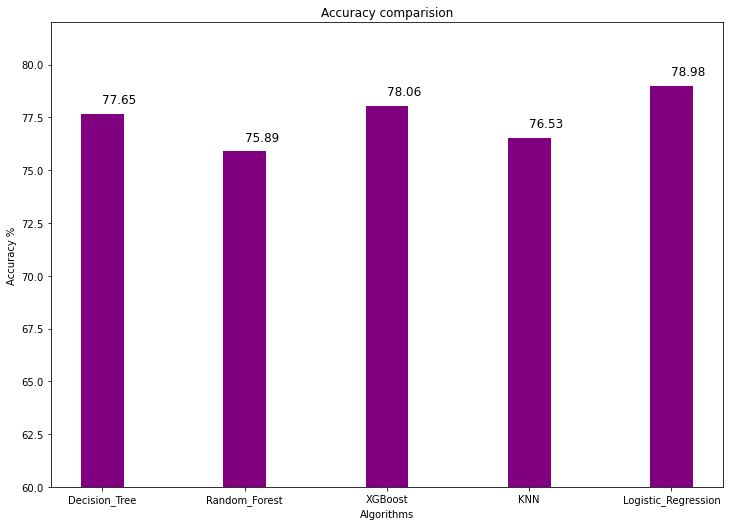

In [137]:
#Accuracy plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(accuracy_df['Algorithm'],accuracy_df['Accuracy'],width=0.3, color='purple')
for index,data in enumerate(accuracy_df['Accuracy']):
    plt.text(x=index, y =data+0.5 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('Accuracy %')
plt.title('Accuracy comparision')
plt.ylim([60,82])
plt.show()

#ROC AUC Score Plot

fig, ax = plt.subplots(figsize = (10,7))
ax.bar(accuracy_df['Algorithm'],accuracy_df['ROC_AUC_SCORE'],width=0.3, color='purple')
for index,data in enumerate(accuracy_df['ROC_AUC_SCORE']):
    plt.text(x=index, y =data+0.5 , s=f"{data}" , fontdict=dict(fontsize=12))
plt.tight_layout()
plt.xlabel('Algorithms')
plt.ylabel('ROC AUC Score %')
plt.title('ROC AUC Score comparision')
plt.ylim([60,100])
plt.show()

#### Plotting Confusion matrix

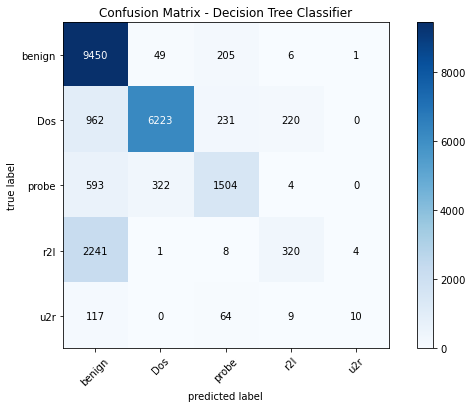

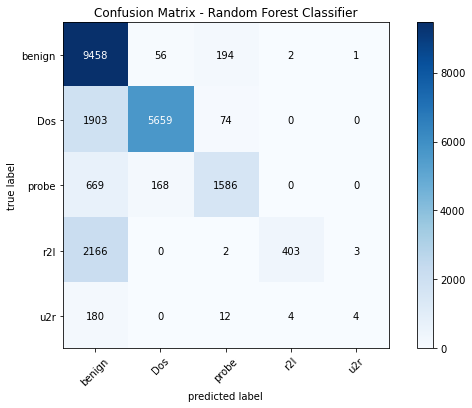

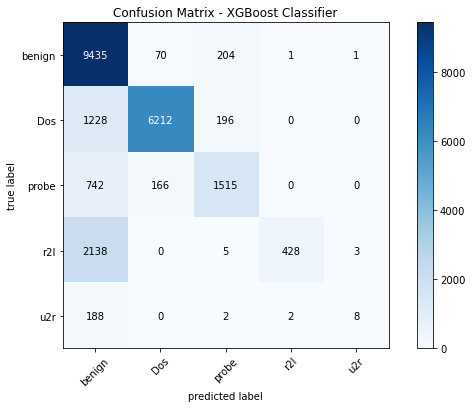

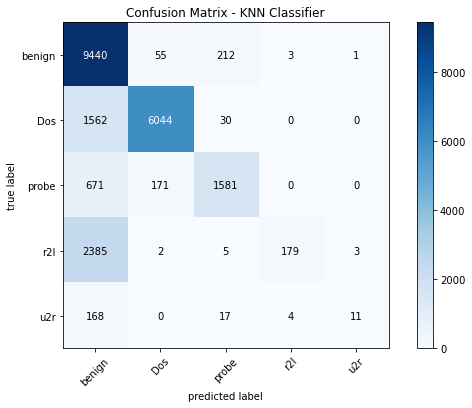

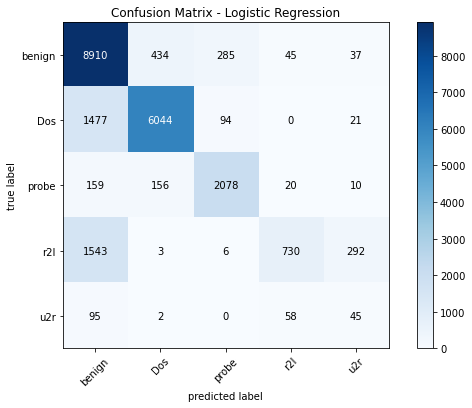

In [135]:
target_attack = ['benign', 'Dos', 'probe', 'r2l', 'u2r']

fig, ax = plot_confusion_matrix(conf_mat=results,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=target_attack, 
                               figsize=(10,6))
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

fig, ax = plot_confusion_matrix(conf_mat=results_rf,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=target_attack, 
                               figsize=(10,6))
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

fig, ax = plot_confusion_matrix(conf_mat=results_xgb,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=target_attack, 
                               figsize=(10,6))
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

fig, ax = plot_confusion_matrix(conf_mat=results_knn,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=target_attack, 
                               figsize=(10,6))
plt.title('Confusion Matrix - KNN Classifier')
plt.show()

fig, ax = plot_confusion_matrix(conf_mat=results_log,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=False,
                                class_names=target_attack, 
                               figsize=(10,6))
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

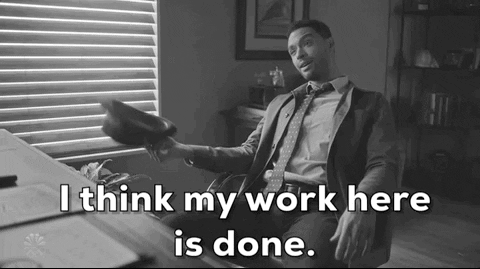